# # Model: Gradient Boosting

### Author: Ehsan Gharib-Nezhad



<a id='gradient'></a>
## Gradient Boosting Models

---
- This is still an ensemble model, but functions a bit differently.
- Again, boosting combines weak learners sequentially so that each new tree can try to correct the errors of the last tree. 
- Weak learners are usually decision trees with only one split. 
- So the first step is to fit a single decision tree with max_depth = 1. 
- We evaluate how well this tree does using a loss function. 
    - Our loss will be high when our actuals and are predictions are very different. 
- The first tree will likely have a high loss, which we want to minimize. We then add another tree that will lower the loss of the first tree. 

**Here’s how that works**. 

- We have a learning rate and we want to find the direction in which the loss decreases the fastest. 
- Mathematically, this is given by the negative derivative loss with respect to the previous models output. 
- SO, we fit the second tree on the gradient of the loss function (aka the derivative of the loss function) with respect to the output of the previous model. 
- It keeps sequentially fitting new models In this way. 

- We have to choose a learning rate for this. We want to choose a learning rate that doesn't go too fast down the gradient and miss our minimum or too slow that it takes out model forever to find that minimum and converge. 


In [1]:
from myfunctions import *

# # Import Bagging Classifier.
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import RandomOverSampler


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [2]:
df = pd.read_csv('../datasets/text_processed_all_posts_combined_imbalanced.csv',index_col=0)
is_balanced = False # set True is the dataset is balanced!!! 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33105 entries, 0 to 33104
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   title               33105 non-null  object
 1   selftext            33105 non-null  object
 2   subreddit           33105 non-null  object
 3   created_utc         33105 non-null  int64 
 4   author              33105 non-null  object
 5   num_comments        33105 non-null  int64 
 6   score               33105 non-null  int64 
 7   is_self             33105 non-null  bool  
 8   timestamp           33105 non-null  object
 9   post                33105 non-null  object
 10  token               33105 non-null  object
 11  is_Covid19positive  33105 non-null  int64 
dtypes: bool(1), int64(4), object(7)
memory usage: 3.1+ MB


### Set up X and Y

In [25]:
X = df['token']
y = df['is_Covid19positive']

In [26]:
#check baseline:

y.value_counts(normalize = True)

1    0.929286
0    0.070714
Name: is_Covid19positive, dtype: float64

# train test split

In [27]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

In [28]:
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(1    0.929273
 0    0.070727
 Name: is_Covid19positive, dtype: float64,
 1    0.929322
 0    0.070678
 Name: is_Covid19positive, dtype: float64)

##  CountVectorizer

In [29]:
cvec = CountVectorizer()

In [30]:
Xcv_train = cvec.fit_transform(X_train)
Xcv_test = cvec.transform(X_test)

# ======================================================
## For imbalanced case

In [31]:
ros = RandomOverSampler()

Xcv_train , y_train = ros.fit_resample(Xcv_train, y_train)

## Model Gradient Boosting

In [32]:
gbc = GradientBoostingClassifier()

In [33]:
gbc.fit(Xcv_train, y_train)

GradientBoostingClassifier()

Score on training set: 0.9412708044382802
Score on testing set: 0.9126495106922798
              precision    recall  f1-score   support

           0       0.44      0.93      0.60       585
           1       0.99      0.91      0.95      7692

    accuracy                           0.91      8277
   macro avg       0.72      0.92      0.78      8277
weighted avg       0.96      0.91      0.93      8277



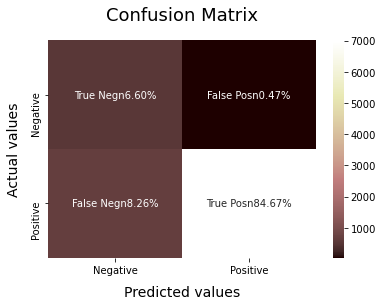

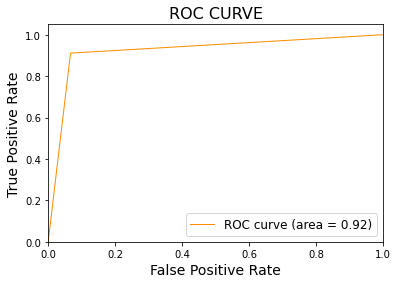

In [34]:
# Evaluate Model
model_Evaluate(gbc, Xcv_train, Xcv_test, y_train, y_test)

In [35]:
save_model_Evaluate_values(gbc, Xcv_train, Xcv_test, y_train, y_test,  
                             model_name='Gradient Boosting', 
                             balanced = is_balanced)

(   score   metric              model balanced
 0   0.94  R_train  Gradient Boosting       no
 1   0.91   R_test  Gradient Boosting       no,
    is_pandemicPreps  is_covid19positive     metric              model balanced
 0              0.44                0.99  precision  Gradient Boosting       no
 1              0.93                0.91     recall  Gradient Boosting       no
 2              0.60                0.95     fscore  Gradient Boosting       no
 3            585.00             7692.00    support  Gradient Boosting       no,
    score     metric              model balanced
 0   0.07   True Neg  Gradient Boosting       no
 1   0.00  False Pos  Gradient Boosting       no
 2   0.08  False Neg  Gradient Boosting       no
 3   0.85   True Pos  Gradient Boosting       no)

# Feature Importance

In [36]:
#create a dataframe for our X_train_cv to use later:

df_X_train = pd.DataFrame(Xcv_train.todense(), columns=cvec.get_feature_names())

In [37]:
f = {'Feature Name':df_X_train.columns,'Feature Importance':gbc.feature_importances_}
et_fi = pd.DataFrame(f)

et_fi.sort_values(by=['Feature Importance'], ascending = False).head(20)

,Feature Name,Feature Importance
16838,symptom,0.300641
17199,test,0.199885
3864,covid,0.091764
13187,posit,0.074405
13377,prep,0.063025
15741,smell,0.028466
6246,fever,0.017651
6186,feel,0.015971
4248,day,0.015165
16391,store,0.012251


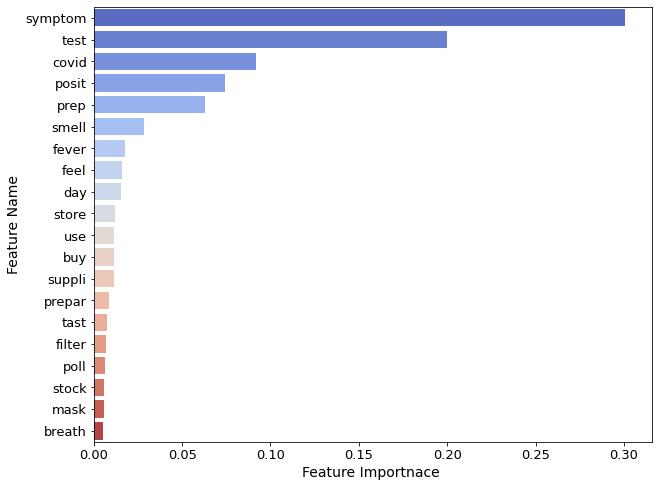

In [38]:
plt.figure( figsize=(10,8))
sns.barplot(x='Feature Importance',y='Feature Name', 
            data=et_fi.sort_values(by='Feature Importance', ascending=False).iloc[0:20],
            palette='coolwarm')
plt.xlabel('Feature Importnace ',fontsize=14)
plt.ylabel('Feature Name', fontsize = 14)
plt.tick_params('both', labelsize = 13)

# ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

# GridSearchCV

In [17]:
params = {
    'n_estimators': [100, 200, 300],
    'loss': ['deviance', 'exponential'],
    'learning_rate': [0.8, 0.9, 1.0]
}

In [18]:

gs = GridSearchCV(GradientBoostingClassifier(), 
                  params, 
                  cv =3)

gs.fit(Xcv_train, y_train)


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.8, 0.9, 1.0],
                         'loss': ['deviance', 'exponential'],
                         'n_estimators': [100, 200, 300]})

In [19]:
gs.best_params_

{'learning_rate': 0.8, 'loss': 'exponential', 'n_estimators': 300}

Score on training set: 0.9891891891891892
Score on testing set: 0.9102564102564102
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       586
           1       0.94      0.90      0.92       740

    accuracy                           0.91      1326
   macro avg       0.91      0.91      0.91      1326
weighted avg       0.91      0.91      0.91      1326



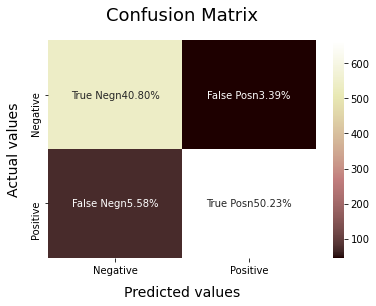

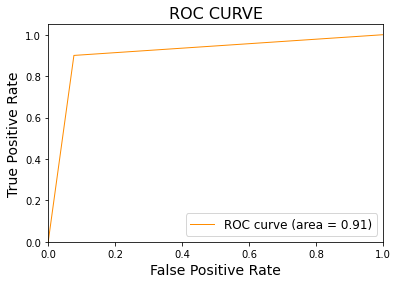

In [20]:
model_Evaluate(gs, Xcv_train, Xcv_test, y_train, y_test)

In [21]:
save_model_Evaluate_values(gs, Xcv_train, Xcv_test, y_train, y_test,  
                             model_name='GradientBoosting-GridSearchCV',
                           balanced = is_balanced)

(   score   metric                          model balanced
 0   0.99  R_train  GradientBoosting-GridSearchCV      yes
 1   0.91   R_test  GradientBoosting-GridSearchCV      yes,
    is_pandemicPreps  is_covid19positive     metric  \
 0              0.88                0.94  precision   
 1              0.92                0.90     recall   
 2              0.90                0.92     fscore   
 3            586.00              740.00    support   
 
                            model balanced  
 0  GradientBoosting-GridSearchCV      yes  
 1  GradientBoosting-GridSearchCV      yes  
 2  GradientBoosting-GridSearchCV      yes  
 3  GradientBoosting-GridSearchCV      yes  ,
    score     metric                          model balanced
 0   0.41   True Neg  GradientBoosting-GridSearchCV      yes
 1   0.03  False Pos  GradientBoosting-GridSearchCV      yes
 2   0.06  False Neg  GradientBoosting-GridSearchCV      yes
 3   0.50   True Pos  GradientBoosting-GridSearchCV      yes)